<center>
    <h1>Rotten vs Fresh Fruit Detection</h1>
</center>

## Libraries

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras
import pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model

## Exploring data

In [2]:
classes = []
class_counter = 0

for dirname, _, filenames in os.walk(r'C:\\Users\\623285\\Downloads\\train\\'):
    if dirname.endswith('\\'):
        continue
    else:
        classes.append({dirname.split('\\')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('\\')[-1]] = file_count
    class_counter += 1
    
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

freshapples     1693           
freshbanana     1581           
freshoranges    1466           
rottenapples    2342           
rottenbanana    2224           
rottenoranges   1595           


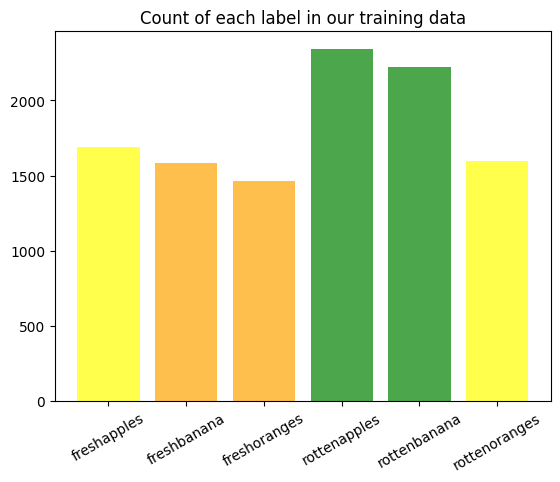

In [3]:
counts = []
labels = []
for d in classes:
    [(k, v)] = d.items()
    labels.append(k)
    counts.append(v)

plt.figure()
plt.bar(range(len(counts)), counts, color = ['yellow', 'orange', 'orange', 'green', 'green', 'yellow'], alpha = .7)
plt.xticks(range(len(counts)), labels, rotation = 30)
plt.title('Count of each label in our training data')
plt.show()

We may have a slight imbalance in our dataset. Orange images are much less than apples.

## Loading data

In [4]:
TRAIN_PATH = r'C:\Users\623285\Downloads\train'
TEST_PATH = r'C:\Users\623285\Downloads\test'

To generate more images we will use Keras' `ImageDataGenerator`.

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = .3, 
    horizontal_flip = True, 
    vertical_flip = True, 
    validation_split = .3
)

train_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'training'
)

validation_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'validation'
)

Found 7634 images belonging to 6 classes.
Found 3267 images belonging to 6 classes.


## Creating model architecture
Note : We will be using VGG-16 for transfert learning

In [19]:
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
vgg16.trainable = False

In [20]:
X_input = Input(shape = (256, 256, 3))
X = vgg16(X_input)
X = AveragePooling2D(pool_size = (3, 3), strides = 2, padding = 'valid',name = 'AvgPool2D')(X)
X = Flatten(name = 'Flatten')(X)
X = Dense(200, activation = 'relu', name = 'Dense1')(X)
X = Dropout(.1)(X)
X = Dense(100, activation = 'relu', name = 'Dense2')(X)
X = Dropout(.1)(X)
X = Dense(6, activation = 'softmax', name = 'Dense3')(X)

model = Model(inputs = X_input, outputs = X, name = 'Fruit_Classifer')

print(model.summary())

Model: "Fruit_Classifer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 AvgPool2D (AveragePooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 Dense1 (Dense)              (None, 200)               921800    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                   

In [21]:
optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
model_fit = model.fit(train_ds, validation_data = validation_ds, epochs = 5, batch_size = 32)

Epoch 1/5
239/239 [==============================] - 1826s 8s/step - loss: 0.8566 - accuracy: 0.8254 - val_loss: 0.1875 - val_accuracy: 0.9446
Epoch 2/5
239/239 [==============================] - 1852s 8s/step - loss: 0.2942 - accuracy: 0.9143 - val_loss: 0.1703 - val_accuracy: 0.9464
Epoch 3/5
239/239 [==============================] - 1969s 8s/step - loss: 0.1973 - accuracy: 0.9394 - val_loss: 0.0763 - val_accuracy: 0.9731
Epoch 4/5
239/239 [==============================] - 1712s 7s/step - loss: 0.1796 - accuracy: 0.9459 - val_loss: 0.1008 - val_accuracy: 0.9691
Epoch 5/5
239/239 [==============================] - 1644s 7s/step - loss: 0.1364 - accuracy: 0.9549 - val_loss: 0.0684 - val_accuracy: 0.9764


## Model evaluation using test data

In [25]:
test_ds = image_dataset_from_directory(
    TEST_PATH,
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (256, 256)
)

Found 2698 files belonging to 6 classes.


In [26]:
results = model.evaluate(test_ds)

print('{:<20} {:<20}'.format('Test loss', 'Test accuracy'))
print('{:<20} {:<20}'.format(np.round(results[0], 2), np.round(results[1], 2)))

85/85 [==============================] - 421s 5s/step - loss: 0.0763 - accuracy: 0.9733
Test loss            Test accuracy       
0.08                 0.97                


## Save and test model 

In [29]:
# save model as h5 file
model.save(model_name + '.h5')

INFO:tensorflow:Assets written to: ram://01910df3-0ecd-47bd-83a1-0aa389b7a314/assets


INFO:tensorflow:Assets written to: ram://01910df3-0ecd-47bd-83a1-0aa389b7a314/assets


In [40]:
# test image
test_img = '' # insert image path

# loading/testing h5 model
h5_model = tf.keras.models.load_model(model_name + '.h5')

In [43]:
train_ds.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [101]:
def test_model(img_path):
    img = image.load_img(img_path ,target_size = (256, 256, 3))
    plt.imshow(img)
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x,axis = 0)
    images = np.vstack([x])

    pred = model.predict(images)
    val = pred.argmax()
    
    if(val ==0):
        print("Fresh Apple")
    elif(val == 1):
        print("Fresh Banana")
    elif(val == 2):
        print("Fresh Orange")
    elif(val == 3):
        print("Rotten Apple")
    elif(val == 4):
        print("Rotten Banana")
    elif(val == 5):
        print("Rotten Orange")
    else:
        print("Fruit not in category")

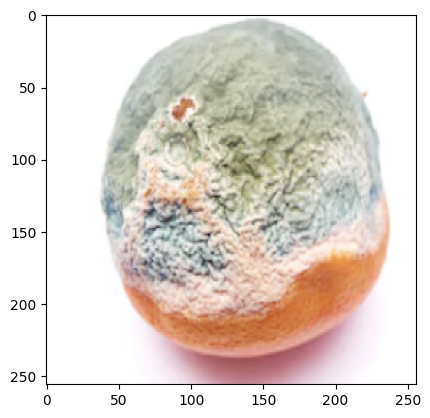

1/1 [==============================] - 0s 127ms/step
Rotten Orange


In [104]:
test_model(test_img)